In [1]:
import os
from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up state and LLMs

In [5]:
class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    current_mode: Literal["router", "account", "music"]

In [6]:
helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

# Helper Functions

In [7]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Music Recommendation Agent

## Create Artist and Song retrievers to allow inexact matching of for artists and tracks/songs names

In [8]:
artists = db._execute("SELECT * FROM artists")
songs = db._execute("SELECT * FROM tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()


song_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in songs],
    OpenAIEmbeddings(),
    metadatas=songs
).as_retriever()

## Define Tools to get recommendations

### Tools not specific to a customer

In [9]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT Title, Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    docs = artist_retriever.get_relevant_documents(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def search_songs(song_title: str):
    """Search for songs by title."""
    docs = song_retriever.get_relevant_documents(song_title)
    return [{"Title": doc.page_content, "TrackId": doc.metadata["TrackId"]} for doc in docs[:5]]


@tool
def get_similar_music(genre: str, artist: str = ""):
    """Get music recommendations based on genre and optionally artist."""
    # Find genre ID
    genre_query = f"""
    SELECT GenreId FROM genres 
    WHERE Name LIKE '%{genre}%' 
    LIMIT 1
    """
    genre_result = db.run(genre_query)
    if not genre_result:
        return f"No genre found matching '{genre}'"

    # Genre result comes as a string like "[(1,)]" - parse it
    genre_id = int(genre_result.strip("[]() \t\n,").split(",")[0])

    # Get tracks in that genre, optionally filtering by artist
    artist_filter = ""
    if artist:
        docs = artist_retriever.get_relevant_documents(artist)
        if docs:
            artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
            artist_filter = f"AND albums.ArtistId IN ({artist_ids})"
    
    query = f"""
    SELECT tracks.Name as TrackName, artists.Name as ArtistName, albums.Title as AlbumTitle
    FROM tracks
    JOIN albums ON tracks.AlbumId = albums.AlbumId
    JOIN artists ON albums.ArtistId = artists.ArtistId
    WHERE tracks.GenreId = {genre_id} {artist_filter}
    ORDER BY RANDOM()
    LIMIT 5
    """
    
    result = db.run(query, include_columns=True)
    
    # Format the result nicely for display
    if not result:
        return f"No songs found for genre '{genre}'" + (f" and artist '{artist}'" if artist else "")
    
    formatted_result = "Here are some similar tracks:\n\n"
    for track in result:
        formatted_result += f"- {track['TrackName']} by {track['ArtistName']} (Album: {track['AlbumTitle']})\n"
    
    return formatted_result
    

### Tools specific to a customer

In [10]:
@tool
def get_customer_top_genres(customer_id: int, limit: int = 5):
    """Identify a customer's favorite genres based on purchase history."""
    return db.run(f"""
        SELECT g.Name as Genre, COUNT(ii.InvoiceLineId) as PurchaseCount
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_customer_top_artists(customer_id: int, limit: int = 5):
    """Identify a customer's favorite artists based on purchase history."""
    return db.run(f"""
        SELECT ar.Name as Artist, COUNT(ii.InvoiceLineId) as PurchaseCount,
               SUM(ii.UnitPrice) as TotalSpent
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def check_track_purchase_history(customer_id: int, track_name: str):
    """Check if and when a customer purchased a specific track."""
    # First, find tracks that match the provided name
    docs = song_retriever.get_relevant_documents(track_name)
    if not docs:
        return f"No tracks found matching '{track_name}'"
    
    track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
    
    return db.run(f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id} AND t.TrackId IN ({track_ids})
        ORDER BY i.InvoiceDate DESC;
    """, include_columns=True)

@tool
def get_recommended_tracks_from_purchase_history(customer_id: int, limit: int = 5):
    """Get personalized track recommendations based on purchase history."""
    # First, get the customer's top genres
    top_genres_query = """
        SELECT g.Name as Genre
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 2;
    """.format(customer_id=customer_id)
    
    genres_result = db.run(top_genres_query, include_columns=True)
    
    if not genres_result:
        return "No purchase history found to base recommendations on."
    
    # Get customer's purchased tracks to exclude them
    purchased_tracks_query = """
        SELECT t.TrackId
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        WHERE i.CustomerId = {customer_id};
    """.format(customer_id=customer_id)
    
    purchased_tracks_result = db.run(purchased_tracks_query)
    purchased_track_ids = []
    if purchased_tracks_result:
        # Extract track IDs from the SQL result
        for row in purchased_tracks_result.strip('[]').split('), ('):
            track_id = row.strip('()').split(',')[0]
            if track_id.isdigit():
                purchased_track_ids.append(int(track_id))
    
    # Get top artists (optional enhancement)
    top_artist_query = """
        SELECT ar.Name as Artist
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 1;
    """.format(customer_id=customer_id)
    
    artist_result = db.run(top_artist_query, include_columns=True)
    top_artist = artist_result[0]['Artist'] if artist_result else ""
    
    # Use the existing get_similar_music with the top genre
    recommendations = get_similar_music(genres_result[0]['Genre'], top_artist)
    
    # You could filter out already purchased tracks here if needed
    
    return recommendations


@tool
def summarize_music_taste(customer_id: int):
    """Provide a data summary of the customer's music taste based on purchase history."""
    summary_query = f"""
    SELECT 
        (SELECT COUNT(DISTINCT ar.ArtistId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         JOIN tracks t ON ii.TrackId = t.TrackId
         JOIN albums al ON t.AlbumId = al.AlbumId
         JOIN artists ar ON al.ArtistId = ar.ArtistId
         WHERE i.CustomerId = {customer_id}) as UniqueArtists,
        
        (SELECT COUNT(DISTINCT g.GenreId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         JOIN tracks t ON ii.TrackId = t.TrackId
         JOIN genres g ON t.GenreId = g.GenreId
         WHERE i.CustomerId = {customer_id}) as UniqueGenres,
        
        (SELECT COUNT(ii.InvoiceLineId) FROM invoice_items ii 
         JOIN invoices i ON ii.InvoiceId = i.InvoiceId
         WHERE i.CustomerId = {customer_id}) as TotalTracks,
        
        (SELECT SUM(i.Total) FROM invoices i 
         WHERE i.CustomerId = {customer_id}) as TotalSpent
    """
    
    stats = db.run(summary_query, include_columns=True)
    
    if not stats or not stats[0]['UniqueArtists']:
        return "No purchase history found for this customer."
    
    # Get top genres string
    top_genres = get_customer_top_genres(customer_id, 3)
    genre_str = ", ".join([g['Genre'] for g in top_genres]) if top_genres else "None found"
    
    # Get top artists string
    top_artists = get_customer_top_artists(customer_id, 3)
    artist_str = ", ".join([a['Artist'] for a in top_artists]) if top_artists else "None found"
    
    return {
        "stats": stats[0],
        "top_genres": genre_str,
        "top_artists": artist_str
    }

In [11]:
music_recommendation_tools = [
    get_albums_by_artist,
    get_tracks_by_artist,
    search_songs,
    get_similar_music,
    get_customer_top_genres,
    get_customer_top_artists,
    check_track_purchase_history,
    get_recommended_tracks_from_purchase_history,
    summarize_music_taste
]
music_recommendation_model_with_tools = music_recommendation_model.bind_tools(music_recommendation_tools)

## Set up graph

### Node to process queries

In [12]:
music_system_message = """You are a music specialist at a music store.
You have extensive knowledge of our music catalog and can assist customers in discovering music they'll love.

FOR ALL CUSTOMERS, YOU CAN:
1. Find albums by specific artists
2. List songs by an artist
3. Search for specific tracks by name
4. Recommend music based on genres or similar artists

FOR AUTHENTICATED CUSTOMERS (when a customer ID is provided), YOU CAN ALSO:
5. Check their purchase history for specific tracks or artists
6. Analyze their music taste based on previous purchases
7. Provide personalized recommendations based on their top genres
8. Suggest new music similar to their favorite artists
9. Summarize their music preferences with insights about their taste

GUIDELINES:
- Be conversational and show enthusiasm about music
- If you can't find exactly what they're looking for, suggest similar alternatives
- When making recommendations, briefly explain why you think they might enjoy them
- For customers with limited purchase history, balance personalized suggestions with popular recommendations
- Use specific examples when discussing artists and genres
- If asked about a purchase they can't recall, offer to check their purchase history

Your goal is to help customers discover music they'll love, whether they're looking for specific tracks or open to new recommendations that match their taste.
"""


def handle_music_query(state: MusicStoreChatbotState):
    """Handle music-related queries"""
    
    messages = [SystemMessage(content=music_system_message)]
    context_messages = filter_messages(state["messages"], exclude_types="system")
    # context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = music_recommendation_model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [response]
    }

### Graph Definition

In [13]:
music_recommendation_graph_builder = StateGraph(MusicStoreChatbotState)

music_recommendation_graph_builder.add_node("handle_music_query", handle_music_query)
music_recommendation_graph_builder.add_node("tools", ToolNode(music_recommendation_tools))

# Add the starting edge
music_recommendation_graph_builder.add_edge(START, "handle_music_query")
music_recommendation_graph_builder.add_conditional_edges(
    "handle_music_query",
    # If the latest message from assistant 
    # is a tool call -> tools_condition routes to tools
    # is a not a tool call -> tools_condition routes to END
    tools_condition,
)
music_recommendation_graph_builder.add_edge("tools", "handle_music_query")
music_recommendation_graph_builder.add_edge("handle_music_query", END)

music_recommendation_memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
music_recommendation_graph = music_recommendation_graph_builder.compile(checkpointer=music_recommendation_memory)

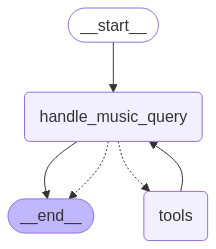

In [14]:
display(Image(music_recommendation_graph.get_graph().draw_mermaid_png()))

## Test

In [15]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

/var/folders/h0/6_6mqq755ks82f6p8nvrzqlr0000gn/T/ipykernel_99810/2826969327.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = artist_retriever.get_relevant_documents(artist)


================================ Human Message =================================

Hey, recommend music by Amy Winehouse
================================== Ai Message ==================================
Tool Calls:
  get_albums_by_artist (call_nothZDtxd8EBT4plrwAE9UlQ)
 Call ID: call_nothZDtxd8EBT4plrwAE9UlQ
  Args:
    artist: Amy Winehouse
================================= Tool Message =================================
Name: get_albums_by_artist

[{'Title': 'Jagged Little Pill', 'ArtistName': 'Alanis Morissette'}, {'Title': 'Audioslave', 'ArtistName': 'Audioslave'}, {'Title': 'Out Of Exile', 'ArtistName': 'Audioslave'}, {'Title': 'Revelations', 'ArtistName': 'Audioslave'}, {'Title': 'Bark at the Moon (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Blizzard of Ozz', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Diary of a Madman (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'No More Tears (Remastered)', 'ArtistName': 'Ozzy Osbourne'}, {'Title': 'Tribute', 'ArtistName':

In [16]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "2"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, recommend songs by Green Day")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, recommend songs by Green Day
================================== Ai Message ==================================
Tool Calls:
  get_tracks_by_artist (call_uLymF3kxUzcYbHs5k3KKlzTB)
 Call ID: call_uLymF3kxUzcYbHs5k3KKlzTB
  Args:
    artist: Green Day
================================= Tool Message =================================
Name: get_tracks_by_artist

[{'SongName': 'Maria', 'ArtistName': 'Green Day'}, {'SongName': 'Poprocks And Coke', 'ArtistName': 'Green Day'}, {'SongName': 'Longview', 'ArtistName': 'Green Day'}, {'SongName': 'Welcome To Paradise', 'ArtistName': 'Green Day'}, {'SongName': 'Basket Case', 'ArtistName': 'Green Day'}, {'SongName': 'When I Come Around', 'ArtistName': 'Green Day'}, {'SongName': 'She', 'ArtistName': 'Green Day'}, {'SongName': 'J.A.R. (Jason Andrew Relva)', 'ArtistName': 'Green Day'}, {'SongName': 'Geek Stink Breath', 'ArtistName': 'Green Day'}, {'SongName': 'Brain Stew',

In [17]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "3"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, is Boulevard Of Broken Dreams available for purchase?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, is Boulevard Of Broken Dreams available for purchase?
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_vAEtQPFX3X09gx6FhHHkFSGp)
 Call ID: call_vAEtQPFX3X09gx6FhHHkFSGp
  Args:
    song_title: Boulevard Of Broken Dreams
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "City Of Blinding Lights", "TrackId": 2968}, {"Title": "Under The Bridge", "TrackId": 2368}, {"Title": "Where The Streets Have No Name", "TrackId": 3010}]
================================== Ai Message ==================================

Yes, "Boulevard Of Broken Dreams" is available for purchase! If you're interested, I can help you with the next steps to get it. Would you like to know more about the artist or similar tracks?


In [18]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "400"}}

# Then use it in your invoke call
response = music_recommendation_graph.invoke(
    {"messages": [HumanMessage(content="Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, I like Boulevard Of Broken Dreams. What other albums and songs would you recommend?
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_qDhE9Ce7x7hgCv7I2faGEjXG)
 Call ID: call_qDhE9Ce7x7hgCv7I2faGEjXG
  Args:
    song_title: Boulevard Of Broken Dreams
  get_similar_music (call_9tVTufexRlXfaTr3GOgY6UNe)
 Call ID: call_9tVTufexRlXfaTr3GOgY6UNe
  Args:
    genre: Rock
    artist: Green Day
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "City Of Blinding Lights", "TrackId": 2968}, {"Title": "Under The Bridge", "TrackId": 2368}, {"Title": "Where The Streets Have No Name", "TrackId": 3010}]
================================= Tool Message =================================
Name: get_similar_music

Error: TypeError("string indi

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [19]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    """
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"

#### Tools for customer transactions

In [20]:
@tool
def get_customer_invoices(customer_id: int, limit: int = 10):
    """Retrieve the most recent invoices for a customer."""
    return db.run(f"""
        SELECT InvoiceId, InvoiceDate, Total 
        FROM invoices 
        WHERE CustomerId = {customer_id}
        ORDER BY InvoiceDate DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)

@tool
def get_recent_purchases(customer_id: int, limit: int = 5):
    """Get the most recent purchases for quick reference."""
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist,
               ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        ORDER BY i.InvoiceDate DESC
        LIMIT {limit};
    """
    return db.run(query, include_columns=True)


@tool
def check_purchase_history(customer_id: int, date_from: str = None, date_to: str = None, 
                          track_name: str = None, artist_name: str = None, album_title: str = None):
    """
    Check purchase history with flexible filtering options.
    Provide at least one filter parameter (date range, track, artist, or album).
    """
    # Build WHERE clause based on provided parameters
    filters = [f"i.CustomerId = {customer_id}"]
    
    if date_from:
        filters.append(f"i.InvoiceDate >= '{date_from}'")
    if date_to:
        filters.append(f"i.InvoiceDate <= '{date_to}'")
        
    # Use retrievers for fuzzy matching where appropriate
    track_filter = ""
    if track_name:
        docs = song_retriever.get_relevant_documents(track_name)
        if docs:
            track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
            filters.append(f"t.TrackId IN ({track_ids})")
    
    artist_filter = ""
    if artist_name:
        docs = artist_retriever.get_relevant_documents(artist_name)
        if docs:
            artist_ids = ", ".join([str(doc.metadata['ArtistId']) for doc in docs[:5]])
            filters.append(f"ar.ArtistId IN ({artist_ids})")
    
    if album_title:
        filters.append(f"al.Title LIKE '%{album_title}%'")
    
    where_clause = " AND ".join(filters)
    
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE {where_clause}
        ORDER BY i.InvoiceDate DESC
        LIMIT 20;
    """
    
    return db.run(query, include_columns=True)

In [21]:
account_query_tool_names = ["query_customer_info"]
account_query_tools = [
    query_customer_info, 
    get_customer_invoices, 
    get_invoice_details, 
    get_spending_history, 
    get_recent_purchases, 
    check_purchase_history
]
account_update_tool_names = ["update_customer_info"]
account_update_tools = [update_customer_info]

In [22]:
account_agent_model_with_tools = account_agent_model.bind_tools(tools=[query_customer_info, update_customer_info])

### Node: Route based on Customer ID

In [23]:
def is_customer_id_known(state: MusicStoreChatbotState) -> dict:
    """Routing based on Customer ID"""
    cutomer_id_is_set = state["customer_id"] is not None
    message = f"Customer ID found: {state["customer_id"]}" if cutomer_id_is_set else "Customer ID not found"
    return {
        "messages": state["messages"] + [SystemMessage(content=message)]
    }


def customer_id_known_route_condition(state: MusicStoreChatbotState) -> bool:
    """Return the routing condition based on the current state"""
    return state["customer_id"] is not None

### Node: Process Account Query

In [24]:
account_system_message = """You are a customer account specialist at a music store.
You can help customers with the following:

1. ACCOUNT MANAGEMENT
   - Retrieve their account information (name, contact details, address)
   - Update their profile details (email, address, phone number, etc.)

2. PURCHASE HISTORY
   - View their recent purchases
   - Find specific purchases by track, artist, or album
   - See detailed invoice information
   - Check purchase dates for specific items

3. FINANCIAL INFORMATION
   - Review spending history over time
   - Get total spending summaries by date ranges
   - View individual invoice details

Guidelines:
- Always verify you're working with the correct customer ID before sharing information
- Provide concise, natural language responses
- For large datasets, summarize the information with key highlights
- If asked about spending patterns, provide helpful insights when possible
- For invoice details, format currency values appropriately
- When discussing purchase history, mention if items are still available for purchase again
- If a user is not found for the provided ID, inform them that the ID is invalid

Your goal is to help customers understand their account activity and purchase history at our music store while providing a helpful, professional experience.
"""

def handle_account_query(state: MusicStoreChatbotState):
    """Handle account-related queries"""
    assert state["customer_id"] is not None
    
    # Build messages for the account agent
    messages = [SystemMessage(content=account_system_message)]
    # Add some conversation context
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Add customer context
    customer_id = state["customer_id"]
    messages.append(SystemMessage(content=f"Current authenticated customer ID: {customer_id}"))

    # Let the agent determine what to do next
    response = account_agent_model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [response]
    }


def handle_account_query_route_condition(state: MusicStoreChatbotState) -> str:
    last_message = state["messages"][-1]
    destination = END

    # Check if the last message has tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Get the name of the called tool
        tool_name = last_message.tool_calls[0]["name"]
        
        # Route to the appropriate tool node
        if tool_name in account_query_tool_names:
            destination = "account_query_tools"
        elif tool_name in account_update_tool_names:
            destination = "account_update_tools"
    
    return destination

### Node: Determine Customer ID

In [25]:
customer_id_prompt = """Your task is to help determine the Customer ID of the user based on their presented chat history. 
If you are able to determine their Customer ID, return just the ID. If the ID cannot be inferred, return UNKNOWN."""

def get_customer_id(state: MusicStoreChatbotState):
    """Fetch the custimer ID if it is part of the query"""
    assert "customer_id" not in state or state["customer_id"] is None
    if "customer_id" not in state:
        print("~" * 100)
        print(state)

    messages = [SystemMessage(content=customer_id_prompt)]
    human_messages = filter_messages(state["messages"], include_types="human")
    messages.extend(human_messages)

    # Let the agent determine what to do next
    response = account_agent_model.invoke(messages)

    # Update the state with the correct department
    content = response.content.lower()
    if content.isdigit():
        return {
            "customer_id": int(content),
            "messages": state["messages"] + [SystemMessage(f"Customer ID found: {content}")]
        }
    else:
        raise NodeInterrupt("Customer ID not found. Please provide your customer ID to proceed.")

def customer_id_valid_route_condition(state: MusicStoreChatbotState) -> Literal["valid", "invalid"]:
    """Return the routing condition based on the current state"""
    # This is just to demonstrate more complex logic can also reside in the route condition.
    # This logic could also be moved up to `get_customer_id`.
    if state["customer_id"] is None:
        return "invalid"
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {state["customer_id"]};")
    if not customer:
        return "invalid"
    return "valid"

### Graph definition

In [26]:
account_agent_graph_builder = StateGraph(MusicStoreChatbotState)
account_agent_graph_builder.add_node("is_customer_id_known", is_customer_id_known)
account_agent_graph_builder.add_node("handle_account_query", handle_account_query)
account_agent_graph_builder.add_node("get_customer_id", get_customer_id)
account_agent_graph_builder.add_node("account_query_tools", ToolNode(account_query_tools))
account_agent_graph_builder.add_node("account_update_tools", ToolNode(account_update_tools))

# Add the starting edge
account_agent_graph_builder.add_edge(START, "is_customer_id_known")
account_agent_graph_builder.add_edge("account_query_tools", "handle_account_query")
account_agent_graph_builder.add_edge("account_update_tools", "handle_account_query")

account_agent_graph_builder.add_conditional_edges(
    "is_customer_id_known",  # Source node
    customer_id_known_route_condition,  # Function that returns the condition value
    {
        True: "handle_account_query",
        False: "get_customer_id",
    }
)

account_agent_graph_builder.add_conditional_edges(
    "handle_account_query",  # Source node
    handle_account_query_route_condition,  # Function that returns the condition value
    {
        "account_update_tools": "account_update_tools",
        "account_query_tools": "account_query_tools",
        END: END
    }
)

account_agent_graph_builder.add_conditional_edges(
    "get_customer_id",  # Source node
    customer_id_valid_route_condition,  # Function that returns the condition value
    {
        "valid": "is_customer_id_known",
        "invalid": END,
    }
)

account_agent_memory = MemorySaver()
account_agent_graph = account_agent_graph_builder.compile(
    interrupt_before=["account_update_tools"],
    # interrupt_after=["get_customer_id"],
    checkpointer=account_agent_memory
)

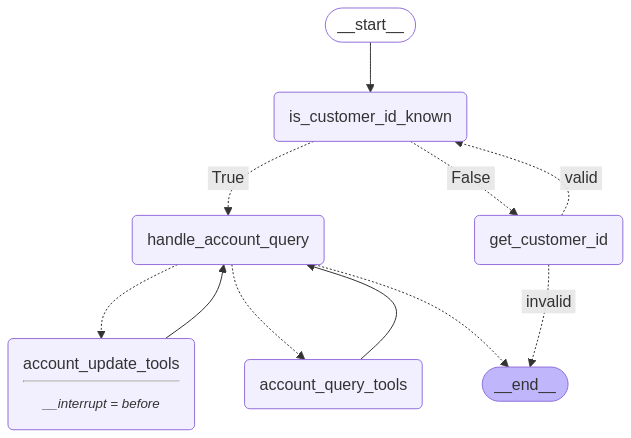

In [27]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

## Test

#### Test fetching account details without providing ID up front

In [28]:
# Input
initial_input = {
    "messages": [HumanMessage(content="I want to check my account details")], 
    "current_mode": "account", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "customer_id_request_4"}}

# Run the graph - it will stop if an interruption occurs
try:
    for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
        # Display messages as they come
        event['messages'][-1].pretty_print()
except Exception as e:
    print(f"Graph execution stopped: {e}")

# Check if there was an interruption
state = account_agent_graph.get_state(thread)
if state.tasks and any(task.interrupts for task in state.tasks):
    # Get the interruption message
    interrupt_task = next(task for task in state.tasks if task.interrupts)
    interrupt_message = interrupt_task.interrupts[0].value
    
    print(f"\nAgent needs more information: {interrupt_message}")
    
    # Get customer ID from user
    customer_id_input = input("Please enter your customer ID: ")
    
    # Validate input
    if customer_id_input.isdigit():
        # Update the state with the provided customer ID
        account_agent_graph.update_state(
            thread,
            {
                "customer_id": int(customer_id_input),
                "current_mode": "account",
                "messages": state.values["messages"] + [
                    HumanMessage(content=f"My customer ID is {customer_id_input}")
                ]
            }
        )
        
        # Continue the graph execution with the updated state
        for event in account_agent_graph.stream(None, thread, stream_mode="values"):
            event['messages'][-1].pretty_print()
    else:
        print("Invalid customer ID. Please enter a numeric ID.")

================================ Human Message =================================

I want to check my account details
================================ System Message ================================

Customer ID not found

Agent needs more information: Customer ID not found. Please provide your customer ID to proceed.


Please enter your customer ID:  19


================================ Human Message =================================

My customer ID is 19
================================== Ai Message ==================================
Tool Calls:
  query_customer_info (call_xFpD5yuH6QG5d2NC3zl9wpee)
 Call ID: call_xFpD5yuH6QG5d2NC3zl9wpee
  Args:
    customer_id: 19
================================= Tool Message =================================
Name: query_customer_info

[(19, 'Tim', 'Goyer', 'Apple Inc.', '1 Infinite Loop', 'Cupertino', 'CA', 'USA', '95014', '+1 (408) 996-1010', '+1 (408) 996-1011', 'tgoyer@apple.com', 3)]
================================== Ai Message ==================================

Here are your account details:

- **Name:** Tim Goyer
- **Company:** Apple Inc.
- **Address:** 1 Infinite Loop, Cupertino, CA, 95014, USA
- **Phone Number:** +1 (408) 996-1010
- **Email:** tgoyer@apple.com

If you need to update any of this information, just let me know!


#### Test fetching account details with ID provided up front

In [29]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "22"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please show me all my information")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, my customer ID is 2. Please show me all my information
================================ System Message ================================

Customer ID not found
================================ System Message ================================

Customer ID found: 2
================================ System Message ================================

Customer ID found: 2
================================== Ai Message ==================================
Tool Calls:
  query_customer_info (call_6o5lzb7k1mUkgZoO46JwmgXo)
 Call ID: call_6o5lzb7k1mUkgZoO46JwmgXo
  Args:
    customer_id: 2
================================= Tool Message =================================
Name: query_customer_info

[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5)]
================================== Ai Message ============================

#### Test updating account attribute

In [30]:
# Input
initial_input = {
    # Leonie@kohler.com, leonekohler@surfeu.de
    "messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to leonekohler@surfeu.de")], 
    "current_mode": "router", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "12"}}

# Run the graph until the first interruption
for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in account_agent_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

# query_customer_info({"customer_id" : 2})

================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to leonekohler@surfeu.de
================================ System Message ================================

Customer ID not found
================================ System Message ================================

Customer ID found: 2
================================ System Message ================================

Customer ID found: 2
================================== Ai Message ==================================
Tool Calls:
  update_customer_info (call_nWLi9BnPZgjskMWdRca05Mzj)
 Call ID: call_nWLi9BnPZgjskMWdRca05Mzj
  Args:
    customer_id: 2
    field: Email
    value: leonekohler@surfeu.de


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  update_customer_info (call_nWLi9BnPZgjskMWdRca05Mzj)
 Call ID: call_nWLi9BnPZgjskMWdRca05Mzj
  Args:
    customer_id: 2
    field: Email
    value: leonekohler@surfeu.de
================================= Tool Message =================================
Name: update_customer_info

Successfully updated Email to 'leonekohler@surfeu.de' for customer 2
================================== Ai Message ==================================

I've successfully updated your email to **leonekohler@surfeu.de**. If you need any further assistance or have other updates, feel free to let me know!


#### Test response query not related to the account

In [31]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey. recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey. recommend music by Amy Winehouse
================================ System Message ================================

Customer ID not found


# Compound Agent

## Set up graph

### Node: Query decomposition

### Node: Request Routing

In [37]:
derive_id_message = """Your task is to determine the customer ID from text that represents a sequence of 
queries from the user.
For example, 
1. if a query says 'My customer ID is 123' then you should return 123.
2. if the query says 'I want to switch from talking about customer 123 to customer 456', then return 456.
If the customer ID is not part of the query, return UNKNOWN.
For example, if the query is 'Recommend music from U2', return UNKNOWN.

When the sequence represents a conversation, like:
```My customer ID is 123. Recommend music by U2.

What is the most popular song by Green Day?
```
you should be able to determine that the customer ID is 123

Return ONLY the customer ID number, ex. '123' or the string 'UNKNOWN'
"""

router_system_message = """You are a helpful customer support assistant for a music store.
Your job is to determine what the customer needs help with and route them to the appropriate department:

1. ACCOUNT - For updating personal information, account details, or authentication
2. MUSIC - For music recommendations, searching for songs/artists, or questions about music inventory
3. UNRELATED - for anything that does not fit into ACCOUNT or MUSIC

Respond with only the name of the department (ACCOUNT, MUSIC or UNRELATED) that best matches their query.
You are provided the conversation history of the user. Determine the appropriate department based on their
most recent request.
If they want to access personal information and have not provided a customer ID, please ask for the ID.
"""

def get_customer_id_from_history(state: MusicStoreChatbotState) -> str:
    human_messages = filter_messages(state["messages"], include_types="human")
    formatted_human_messages = "\n\n".join([m.content for m in human_messages])
    derived_id_response = helpdesk_agent_model.invoke([SystemMessage(content=derive_id_message)] + human_messages)
    return derived_id_response.content


def route_conversation(state: MusicStoreChatbotState) -> dict:
    """Route the conversation to the appropriate department"""
    state_update = {}  # stores the partial update returned by this function

    # check if the user ID is available in the latest human query
    derived_id = get_customer_id_from_history(state)
    if derived_id.isdigit() and int(derived_id) != state["customer_id"]:
        state_update["customer_id"] = int(derived_id)
    elif state["customer_id"] is None:
        raise NodeInterrupt("Please provide your customer ID to help me assist you better.")

    #### QUERY DECOMPOSITION
    # TODO

    #### DECOMPOSED QUERY ROUTING
    # TODO
    
    # ROUTING
    human_messages = filter_messages(state["messages"], include_types="human")
    router_messages = [SystemMessage(content=router_system_message)] + human_messages
    response = helpdesk_agent_model.invoke(router_messages)

    # Update the state with the correct department
    content = response.content.lower()
    if "account" in content:
        department = "account"
    elif "music" in content:
        department = "music"
    else:
        department = "unrelated"

    # Return the routing decision
    return {
        "current_mode": department,
        "messages": [SystemMessage(f"Request classified as `{department}`")]
    }


def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

### Node: Out of Scope Queries

In [38]:
def out_of_scope_message_node(state: MusicStoreChatbotState):
    """Node that mocks an agent that can respond only with a default message for unrelated queries."""
    response = "I can only help with music recommendations and account updates. Please try again"
    return {
        "messages": state["messages"] + [AIMessage(response)]
    }

### Graph definition

In [39]:
front_desk_graph_builder = StateGraph(MusicStoreChatbotState)
front_desk_graph_builder.add_node("route_conversation", route_conversation)
front_desk_graph_builder.add_node("music_node", music_recommendation_graph_builder.compile())
# front_desk_graph_builder.add_node("account_node", account_node)
front_desk_graph_builder.add_node("account_node", account_agent_graph_builder.compile())
front_desk_graph_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
front_desk_graph_builder.add_edge(START, "route_conversation")

# Add conditional edges - this is the key part
front_desk_graph_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# Add the ending edges
front_desk_graph_builder.add_edge("music_node", END)
front_desk_graph_builder.add_edge("account_node", END)
front_desk_graph_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
front_desk_graph = front_desk_graph_builder.compile(checkpointer=memory)

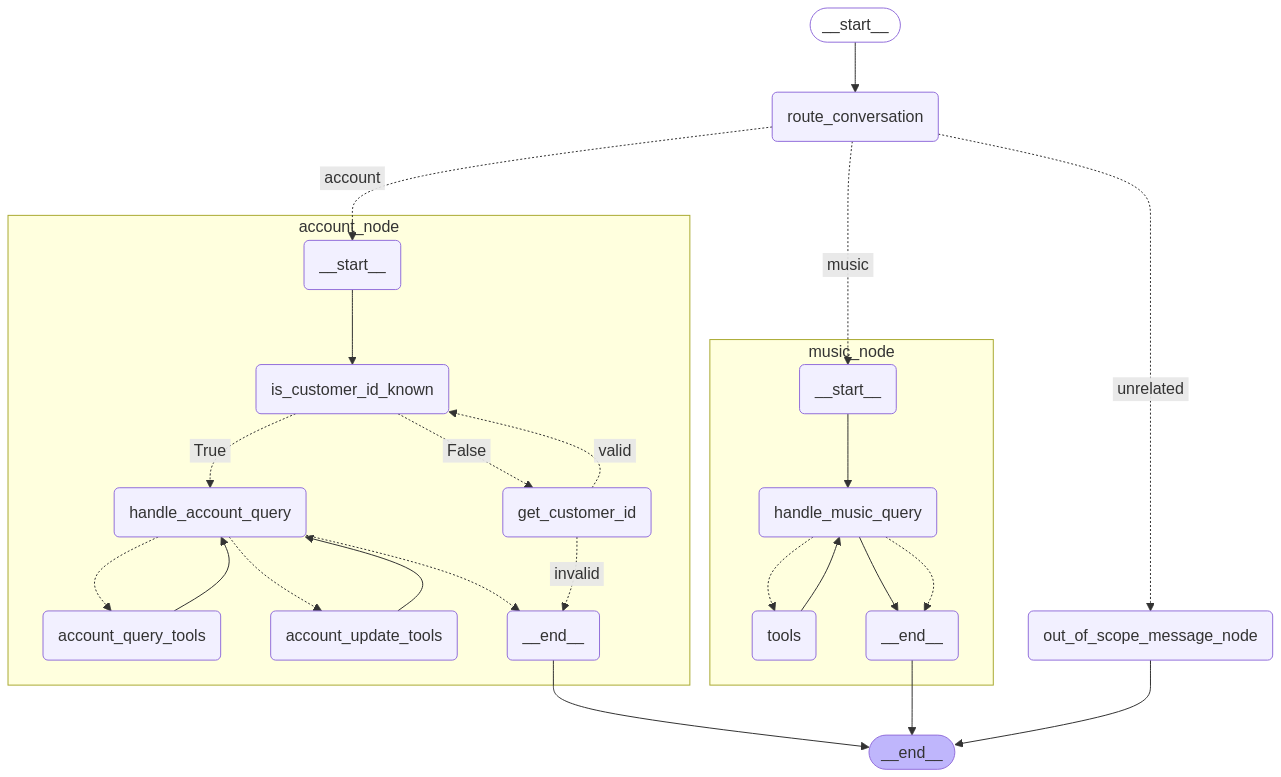

In [40]:
display(Image(front_desk_graph.get_graph(xray=True).draw_mermaid_png()))

## Test

In [41]:
thread_config = {"configurable": {"thread_id": "31-1"}}

response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?")],
        "customer_id": None,
        "current_mode": "router"
    },
    thread_config
)

for m in response["messages"]:
    m.pretty_print()


response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Based on my purchase history, how would you describe my taste in music?")],
        "customer_id": None,
        "current_mode": "router"
    },
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, my customer ID is 2. Is Boulevard of Broken Dreams available at the store?
================================ System Message ================================

Request classified as `music`
================================== Ai Message ==================================
Tool Calls:
  search_songs (call_cCSkveTExgMXztwpp38BYnam)
 Call ID: call_cCSkveTExgMXztwpp38BYnam
  Args:
    song_title: Boulevard of Broken Dreams
================================= Tool Message =================================
Name: search_songs

[{"Title": "Boulevard Of Broken Dreams", "TrackId": 1136}, {"Title": "Infinite Dreams", "TrackId": 1372}, {"Title": "Dream Of Mirrors", "TrackId": 1240}, {"Title": "Dream Of Mirrors", "TrackId": 1362}]
================================== Ai Message ==================================
Tool Calls:
  check_track_purchase_history (call_g3ClPcr2H1VppCOlQU3ufOzo)
 Call ID: call_g3ClPcr2H1VppCOlQU3uf

In [42]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "32"}}

# Then use it in your invoke call
response = front_desk_graph.invoke(
    {"messages": [HumanMessage(content="What is the meaning of life?")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the meaning of life?


In [43]:
# Input
initial_input = {
    "messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to l@k.com")], 
    "current_mode": "router", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "33"}}

# Run the graph until the first interruption
for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in account_agent_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to l@k.com
================================ System Message ================================

Customer ID not found
================================ System Message ================================

Customer ID found: 2
================================ System Message ================================

Customer ID found: 2
================================== Ai Message ==================================
Tool Calls:
  update_customer_info (call_fIWETKGlUIwZiqAUFt4ProIH)
 Call ID: call_fIWETKGlUIwZiqAUFt4ProIH
  Args:
    customer_id: 2
    field: Email
    value: l@k.com


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  update_customer_info (call_fIWETKGlUIwZiqAUFt4ProIH)
 Call ID: call_fIWETKGlUIwZiqAUFt4ProIH
  Args:
    customer_id: 2
    field: Email
    value: l@k.com
================================= Tool Message =================================
Name: update_customer_info

Successfully updated Email to 'l@k.com' for customer 2
================================== Ai Message ==================================

I've successfully updated your email to "l@k.com." If you need any further assistance or have other updates, feel free to let me know!


In [44]:
thread_config = {"configurable": {"thread_id": "34"}}

response = front_desk_graph.invoke(
    {
        "messages": [HumanMessage(content="Hey, my customer ID is 2. Please show me my details")], 
        "current_mode": "router", 
        "customer_id": None
    }, 
    thread_config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey, my customer ID is 2. Please show me my details
================================ System Message ================================

Request classified as `account`
================================ System Message ================================

Customer ID not found
================================ System Message ================================

Customer ID found: 2
================================ System Message ================================

Customer ID found: 2
================================== Ai Message ==================================
Tool Calls:
  query_customer_info (call_W1UCnZemyACskxuom5k020OL)
 Call ID: call_W1UCnZemyACskxuom5k020OL
  Args:
    customer_id: 2
================================= Tool Message =================================
Name: query_customer_info

[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', Non

In [45]:
# Input
initial_input = {
    "messages": [HumanMessage(content="Is Boulevard of Broken Dreams available in the store?")], 
    "current_mode": "router", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "33-1"}}

# Run the graph until the first interruption
for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in account_agent_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Is Boulevard of Broken Dreams available in the store?
================================ System Message ================================

Customer ID not found


Do you want to call the tool? (yes/no):  24


Operation cancelled by user.
